<a href="https://colab.research.google.com/github/alenready/ML_AI_ICT-Assignments/blob/main/Case_study03_Computer_vision_Fruits%26Vegetables1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.15.0 tensorflow-hub keras==2.15.0 -q
!pip install kaggle -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.3 MB/s eta 0:00:00


In [31]:
# Regular Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib
import zipfile
import PIL
import datetime as dt

# TensorFlow
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition

In [ ]:
def extract_data(zip_file : str,
                 data_path : str = '/content/data/'):
  """
  Extracts zipfile into data path given.

  Args:
    zip_file (str): Path of zip folder contains data.
    data_path (str): Path data folder that data to be extracted.
  """
  # Create data folder if does not exist
  data_path_ = pathlib.Path(data_path)
  if data_path_.is_file():
    print(f"{data_path_} folder already exists.")
  else:
    print(f"{data_path_} folder does not exist, creating new one...")
    os.mkdir(data_path_)

    # Extract zipfile into data folder
    print("Extracting the zip folder...")
    zip_ref = zipfile.ZipFile(zip_file)
    zip_ref.extractall(path = data_path_)
    zip_ref.close()
    print("Zip folder has extracted.")

In [8]:
extract_data(zip_file = "/content/fruit-and-vegetable-image-recognition.zip")

/content/data folder does not exist, creating new one...
Extracting the zip folder...
Zip folder has extracted.


In [9]:
# Create data, train, validation and test paths
data_path = pathlib.Path('/content/data/')
train_path = pathlib.Path('/content/data/train')
validation_path = pathlib.Path('/content/data/validation')
test_path = pathlib.Path('/content/data/test')

In [10]:
files = 0
for dirpath, dirnames, filenames in os.walk(data_path):
  files += len(filenames)

print(files)

3825


In [34]:
# class names in train data set, test dataset and validation data set

import os

# Define paths (assuming they are defined in the previous code)
train_path = pathlib.Path('/content/data/train')
validation_path = pathlib.Path('/content/data/validation')
test_path = pathlib.Path('/content/data/test')


def get_class_names(path):
  """
  Returns a list of class names (subdirectory names) within the given path.
  """
  return [name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))]


# Get class names for each dataset
train_class_names = get_class_names(train_path)
validation_class_names = get_class_names(validation_path)
test_class_names = get_class_names(test_path)

# Print the results
print("Train Class Names:", train_class_names)
print("Validation Class Names:", validation_class_names)
print("Test Class Names:", test_class_names)

Train Class Names: ['peas', 'apple', 'watermelon', 'jalepeno', 'onion', 'pomegranate', 'paprika', 'soy beans', 'chilli pepper', 'capsicum', 'tomato', 'orange', 'mango', 'cucumber', 'grapes', 'lettuce', 'sweetpotato', 'pineapple', 'garlic', 'carrot', 'pear', 'ginger', 'cabbage', 'beetroot', 'turnip', 'lemon', 'corn', 'raddish', 'potato', 'spinach', 'bell pepper', 'cauliflower', 'banana', 'eggplant', 'kiwi', 'sweetcorn']
Validation Class Names: ['peas', 'apple', 'watermelon', 'jalepeno', 'onion', 'pomegranate', 'paprika', 'soy beans', 'chilli pepper', 'capsicum', 'tomato', 'orange', 'mango', 'cucumber', 'grapes', 'lettuce', 'sweetpotato', 'pineapple', 'garlic', 'carrot', 'pear', 'ginger', 'cabbage', 'beetroot', 'turnip', 'lemon', 'corn', 'raddish', 'potato', 'spinach', 'bell pepper', 'cauliflower', 'banana', 'eggplant', 'kiwi', 'sweetcorn']
Test Class Names: ['peas', 'apple', 'watermelon', 'jalepeno', 'onion', 'pomegranate', 'paprika', 'soy beans', 'chilli pepper', 'capsicum', 'tomato', 

In [35]:
def create_train_valid_test_df(train_path = train_path,
                               validation_path = validation_path,
                               test_path = test_path):
  """
  Creates train, validation and test datasets from folder paths.

  Args:
    train_path (Path): Path of train folder.
    validation_path (Path): Path of validation folder.
    test_path (Path): Path of test folder.

  Returns:
    (train_df, validation_df, test_df)
  """
  # Create train dataframe
  train_image_paths = [str(pathlib.Path(path)) for path in list(train_path.glob('*/*'))]
  train_image_labels = [path.parent.name for path in list(train_path.glob('*/*'))]
  train_df = pd.DataFrame({
      'image' : train_image_paths,
      'label' : train_image_labels
  })

  # Create validation dataframe
  validation_image_paths = [str(pathlib.Path(path)) for path in list(validation_path.glob('*/*'))]
  validation_image_labels = [path.parent.name for path in list(validation_path.glob('*/*'))]

  validation_df = pd.DataFrame({
      'image' : validation_image_paths,
      'label' : validation_image_labels
  })

  # Create test dataframe
  test_image_paths = [str(pathlib.Path(path)) for path in list(test_path.glob('*/*'))]
  test_image_labels = [path.parent.name for path in list(test_path.glob('*/*'))]

  test_df = pd.DataFrame({
      'image' : test_image_paths,
      'label' : test_image_labels
  })
# Print information about folders
  print(f"There are {len(train_df)} images in train folder.")
  print(f"There are {len(validation_df)} images in validation folder.")
  print(f"There are {len(test_df)} images in test folder.")

  return train_df, validation_df, test_df

In [12]:
train_df, validation_df, test_df = create_train_valid_test_df()

There are 3115 images in train folder.
There are 351 images in validation folder.
There are 359 images in test folder.


In [13]:
# prompt: install visualisation libraries

!pip install matplotlib seaborn -q
import matplotlib.pyplot as plt
import seaborn as sns

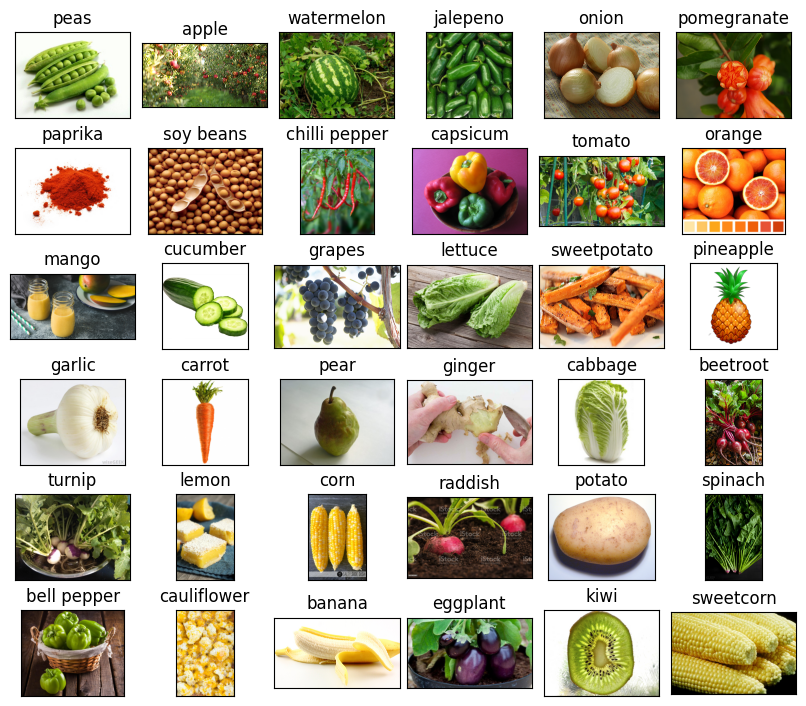

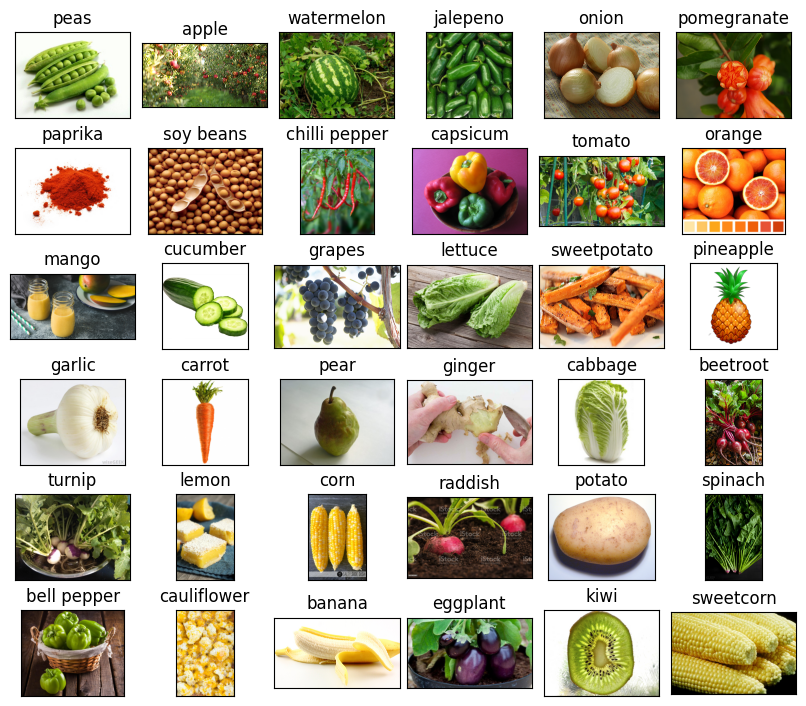

In [39]:
 #Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["label"]).reset_index() # Changed "Label" to "label"

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.image[i])) # Assuming 'image' column has file paths
    ax.set_title(df_unique.label[i], fontsize = 12) # Changed "Label" to "label"
plt.tight_layout(pad=0.5)
plt.show()
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.image[i])) # Assuming 'image' column has file paths
    ax.set_title(df_unique.label[i], fontsize = 12) # Changed "Label" to "label"
plt.tight_layout(pad=0.5)
plt.show()

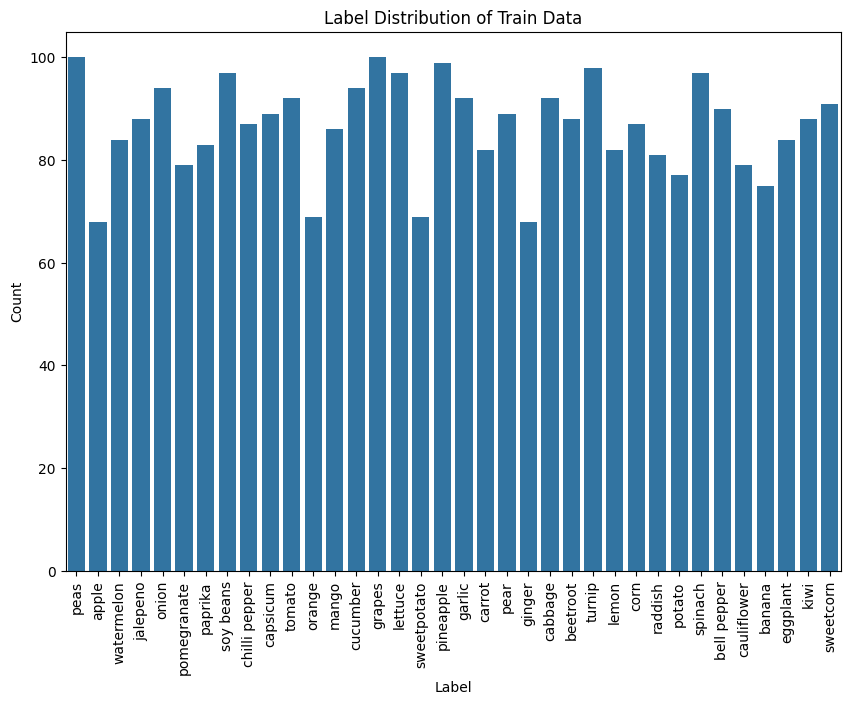

In [14]:
plt.figure(figsize = (10, 7))
plt.title("Label Distribution of Train Data")
plt.xlabel("Label")
plt.ylabel("Count")
sns.countplot(data = train_df, x = "label")
plt.xticks(rotation = 90)
plt.show()

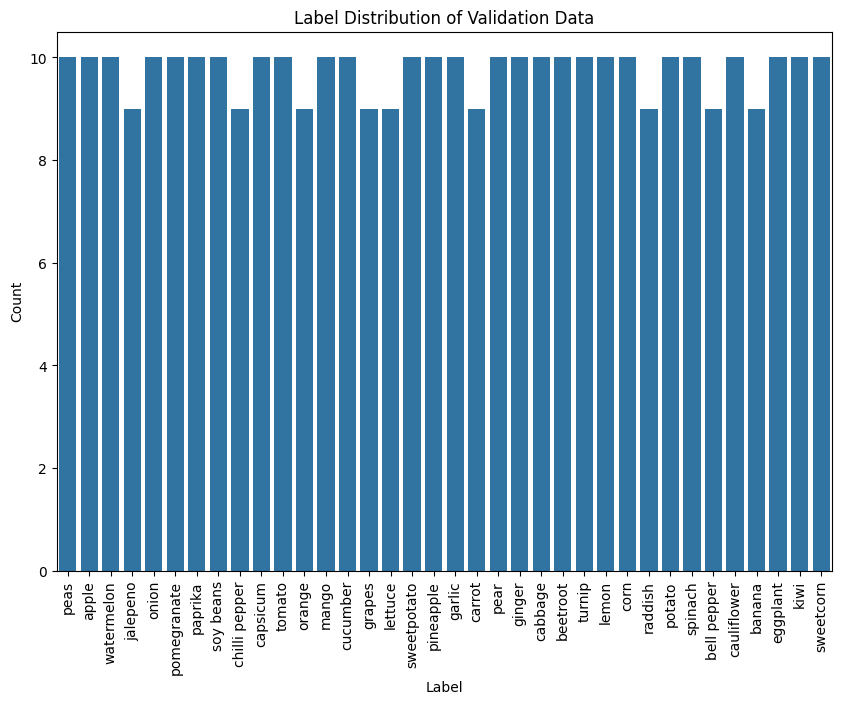

In [15]:
plt.figure(figsize = (10, 7))
plt.title("Label Distribution of Validation Data")
plt.xlabel("Label")
plt.ylabel("Count")
sns.countplot(data = validation_df, x = "label")
plt.xticks(rotation = 90)
plt.show()

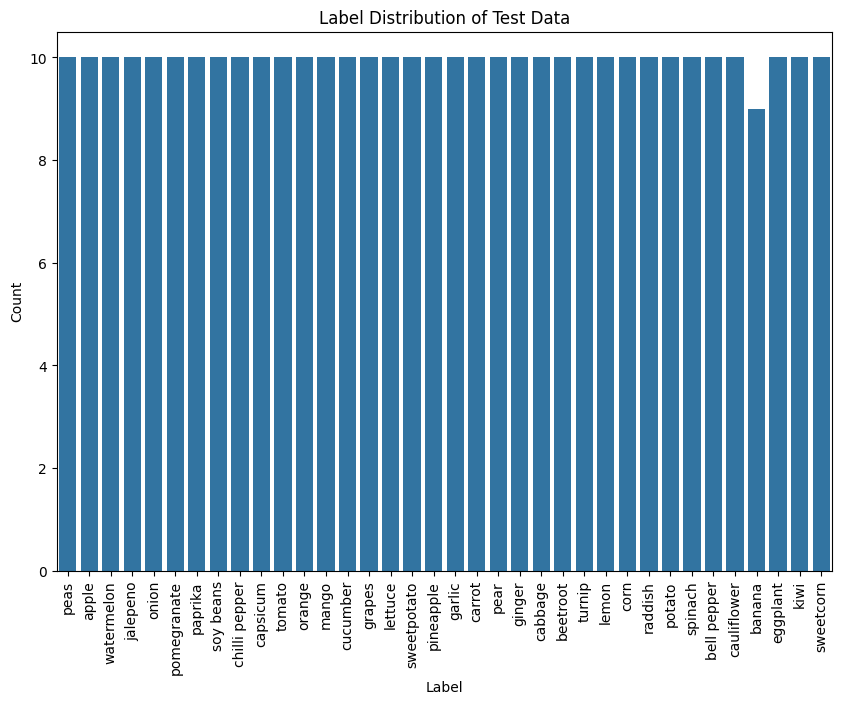

In [16]:
plt.figure(figsize = (10, 7))
plt.title("Label Distribution of Test Data")
plt.xlabel("Label")
plt.ylabel("Count")
sns.countplot(data = test_df, x = "label")
plt.xticks(rotation = 90)
plt.show()

In [17]:
# Let's remind the folder paths.
print(train_path)
print(validation_path)
print(test_path)

/content/data/train
/content/data/validation
/content/data/test


In [18]:
# Setup data inputs
BATCH_SIZE = 32
IMAGE_SHAPE = (224, 224)

# Create ImageDataGenerator objects
train_datagen = ImageDataGenerator(rescale = 1/255.)
validation_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

# Create data flows
print("Train data:")
train_data = train_datagen.flow_from_directory(train_path,
                                               target_size = IMAGE_SHAPE,
                                               shuffle = True,
                                               batch_size = BATCH_SIZE)

print("Validation data:")
validation_data = train_datagen.flow_from_directory(validation_path,
                                                    target_size = IMAGE_SHAPE,
                                                    batch_size = BATCH_SIZE)

print("Test data")
test_data = test_datagen.flow_from_directory(test_path,
                                             target_size = IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE)

Train data:
Found 3115 images belonging to 36 classes.
Validation data:
Found 351 images belonging to 36 classes.
Test data
Found 359 images belonging to 36 classes.


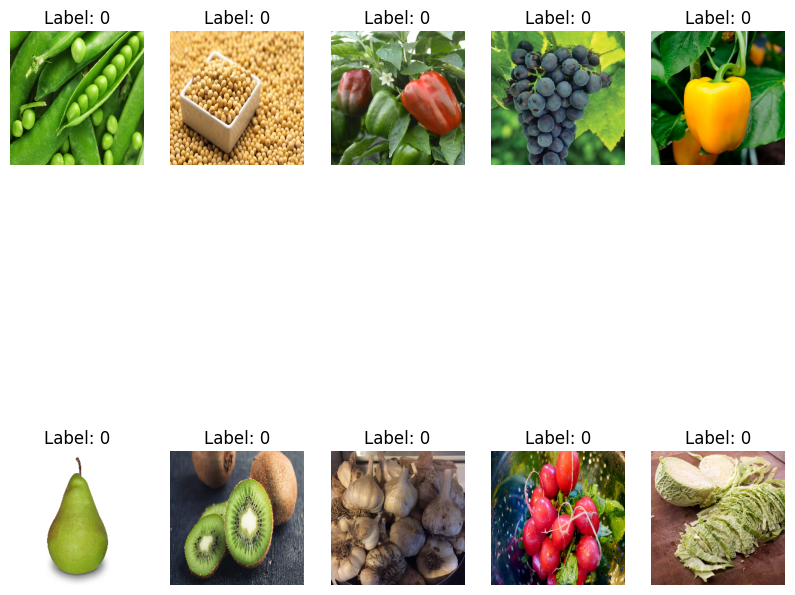

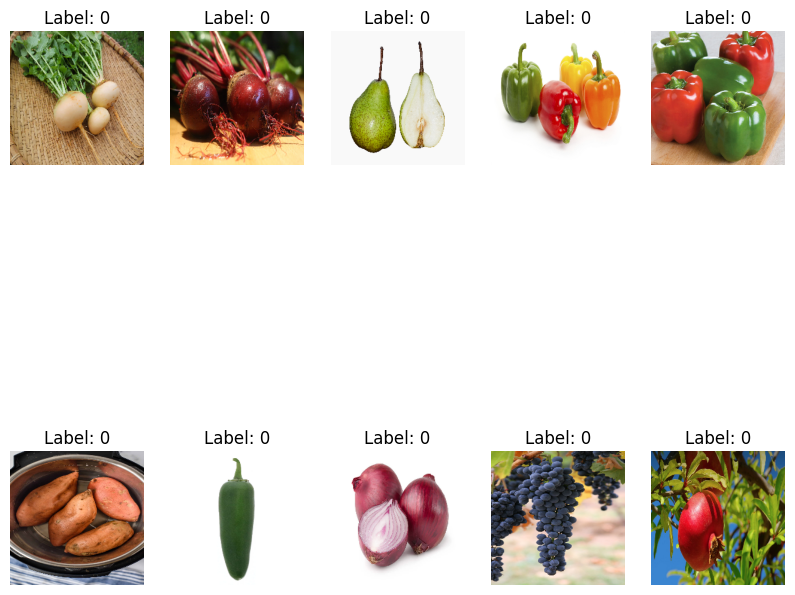

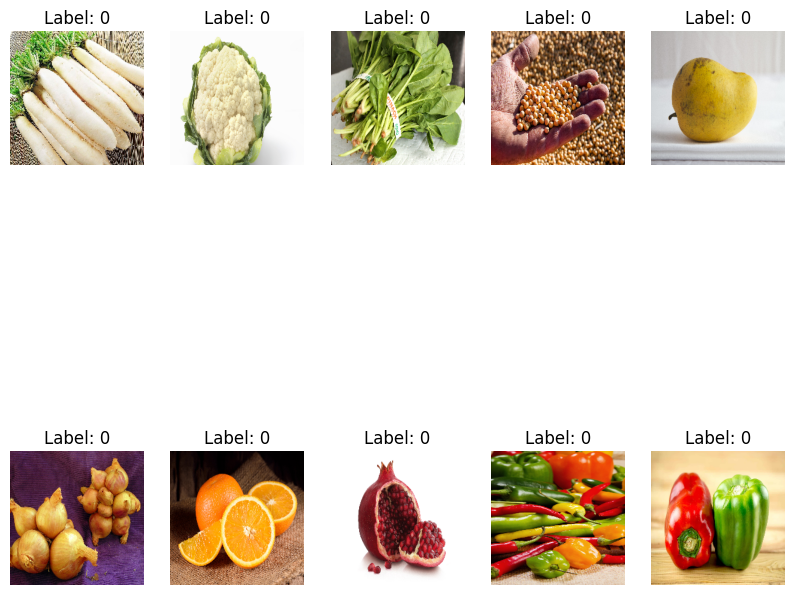

In [28]:


import matplotlib.pyplot as plt

# Visualize images from train data
plt.figure(figsize=(10, 10))
for i in range(10):
    image, label = train_data[0]  # Get a batch of images (first batch)
    plt.subplot(2, 5, i + 1)
    plt.imshow(image[i])
    plt.title(f"Label: {train_data.class_indices[train_data.filenames[i].split('/')[0]]}")
    plt.axis('off')
plt.show()

# Visualize images from validation data
plt.figure(figsize=(10, 10))
for i in range(10):
    image, label = validation_data[0]
    plt.subplot(2, 5, i + 1)
    plt.imshow(image[i])
    plt.title(f"Label: {validation_data.class_indices[validation_data.filenames[i].split('/')[0]]}")
    plt.axis('off')
plt.show()


# Visualize images from test data
plt.figure(figsize=(10, 10))
for i in range(10):
    image, label = test_data[0]
    plt.subplot(2, 5, i + 1)
    plt.imshow(image[i])
    plt.title(f"Label: {test_data.class_indices[test_data.filenames[i].split('/')[0]]}")
    plt.axis('off')
plt.show()

In [19]:
# Create TensorBoard callback
def create_tensorboard_callback(dir_name,
                                experiment_name):
  """
  Creates TensorBoard callback to save model experimentation results
  into related folder.
  """
  log_dir = dir_name + '/' + experiment_name + dt.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)
  print(f"Saving TensorBoard log files to {log_dir}")
  return tensorboard_callback

In [20]:
# Let's compare the following two models
resnet_url = "https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/50-feature-vector/2"
efficientnet_url = "https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet1k-b0-feature-vector/2"

In [21]:
# Let's create a function to create model sequential for us.

def create_model(model_url,
                 num_classes,
                 image_shape):
  """
  Creates Keras Sequential from model URL.

  Args:
    model_url (str): URL of the model taken from Kaggle.
    num_classes (int): Number of classes to be classified.
    image_shape (Tuple): Input shape of images given in tuple format.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pre-trained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False,
                                           name = "feature_extractor_layer",
                                           input_shape = image_shape + (3,))

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      tf.keras.layers.Dense(num_classes, activation = 'softmax', name = 'output_layer')
  ])
   # Return the model
  return model

In [22]:
# Define number of classes and image shape
NUM_CLASSES = train_data.num_classes
IMAGE_SHAPE = (224, 224)

# Create model
resnet_model = create_model(model_url = resnet_url,
                            num_classes = NUM_CLASSES,
                            image_shape = IMAGE_SHAPE)

# Compile the model
resnet_model.compile(loss = 'CategoricalCrossentropy',
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

In [23]:
# Fit the model
resnet_history = resnet_model.fit(train_data,
                                  epochs = 3,
                                  callbacks = [create_tensorboard_callback('transfer_learning_exps',
                                                                           'resnet50v2_10epochs')],
                                  validation_data = validation_data)

Saving TensorBoard log files to transfer_learning_exps/resnet50v2_10epochs20250105-074015
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


98/98 [==============================] - 630s 6s/step - loss: 1.7456 - accuracy: 0.5300 - val_loss: 0.5352 - val_accuracy: 0.8604
Epoch 2/10
98/98 [==============================] - 583s 6s/step - loss: 0.6298 - accuracy: 0.8212 - val_loss: 0.3429 - val_accuracy: 0.9145
Epoch 3/10
98/98 [==============================] - 584s 6s/step - loss: 0.4083 - accuracy: 0.8848 - val_loss: 0.2831 - val_accuracy: 0.9231
Epoch 4/10
98/98 [==============================] - 583s 6s/step - loss: 0.2921 - accuracy: 0.9246 - val_loss: 0.2279 - val_accuracy: 0.9373
Epoch 5/10
98/98 [==============================] - 581s 6s/step - loss: 0.2213 - accuracy: 0.9502 - val_loss: 0.2061 - val_accuracy: 0.9544
Epoch 6/10
98/98 [==============================] - 598s 6s/step - loss: 0.1725 - accuracy: 0.9647 - val_loss: 0.1850 - val_accuracy: 0.9601
Epoch 7/10
98/98 [==============================] - 575s 6s/step - loss: 0.1363 - accuracy: 0.9782 - val_loss: 0.1682 - val_accuracy: 0.9601
Epoch 8/10
98/98 [======

In [49]:
# Let's create a function to plot accuracy and loss curves

def plot_accuracy_and_loss(history):
  """
  Plots accuracy and loss graphs seperately for a fitted model.

  Args:
    history: History dictionary of the model.
  """

  # Calculate the epochs
  epochs = range(1, len(history.history['accuracy']) + 1)

  # Plot a figure
  plt.figure(figsize = (14, 6))

  # Plot the accuracy graph
  plt.subplot(1, 2, 1)
  plt.title("Train and Validation Accuracy")
  plt.plot(epochs, history.history['accuracy'], label = "Train Accuracy")
  plt.plot(epochs, history.history['val_accuracy'], label = "Validation Accuracy")
  plt.legend()

  # Plot the loss graph
  plt.subplot(1, 2, 2)
  plt.title("Train and Validation Loss")
  plt.plot(epochs, history.history['loss'], label = "Train Loss")
  plt.plot(epochs, history.history['val_loss'], label = "Validation Loss")
  plt.legend()

In [44]:
# Predict the label of the test_images
pred = resnet_model.predict(test_data) # Changed 'model' to 'resnet_model' and 'test_images' to 'test_data'
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_data.class_indices) # Changed 'train_images' to 'train_data'
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Assuming 'test_data' has a 'classes' attribute (like 'train_data' and 'validation_data')
y_test = [labels[k] for k in test_data.classes] # Changed 'test_images' to 'test_data'

12/12 [==============================] - 64s 5s/step


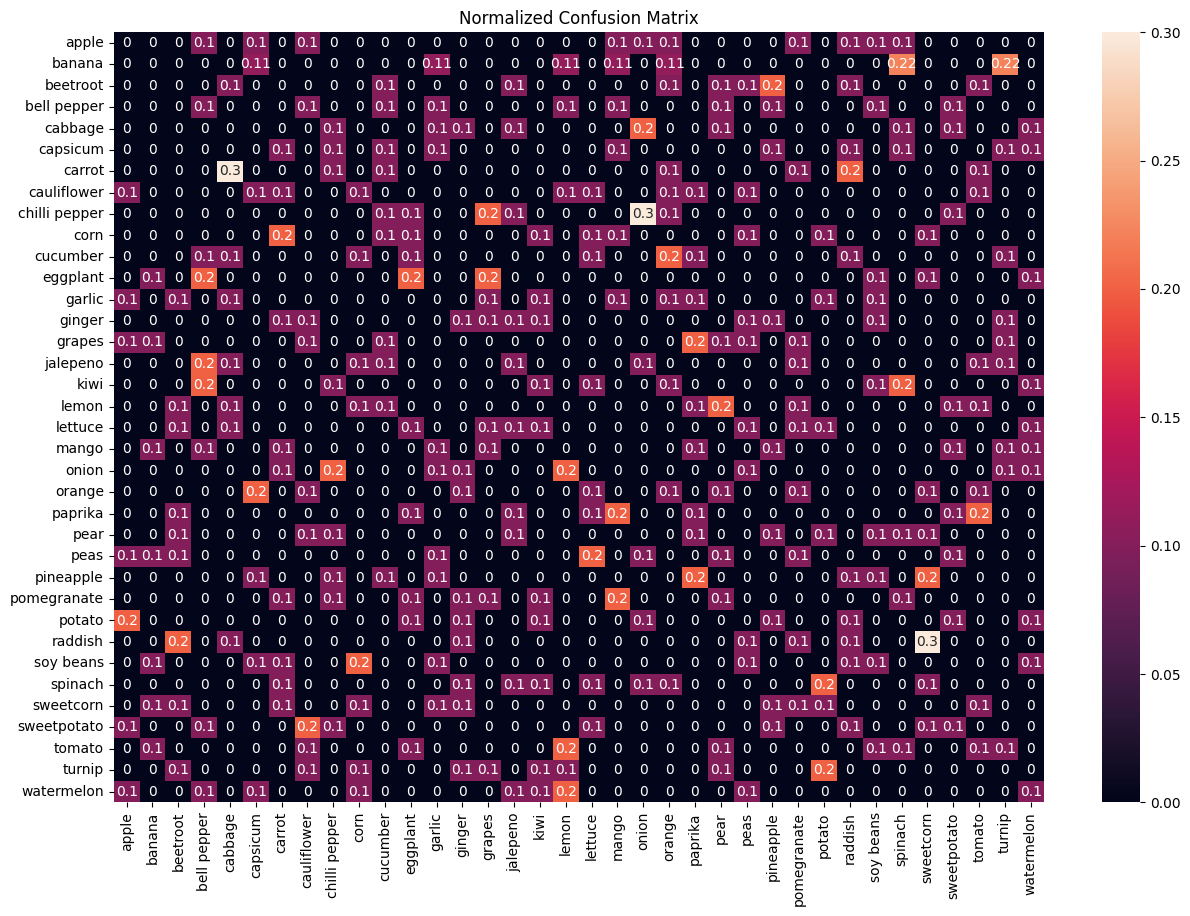

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix,
            annot=True,
            xticklabels = sorted(set(y_test)),
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

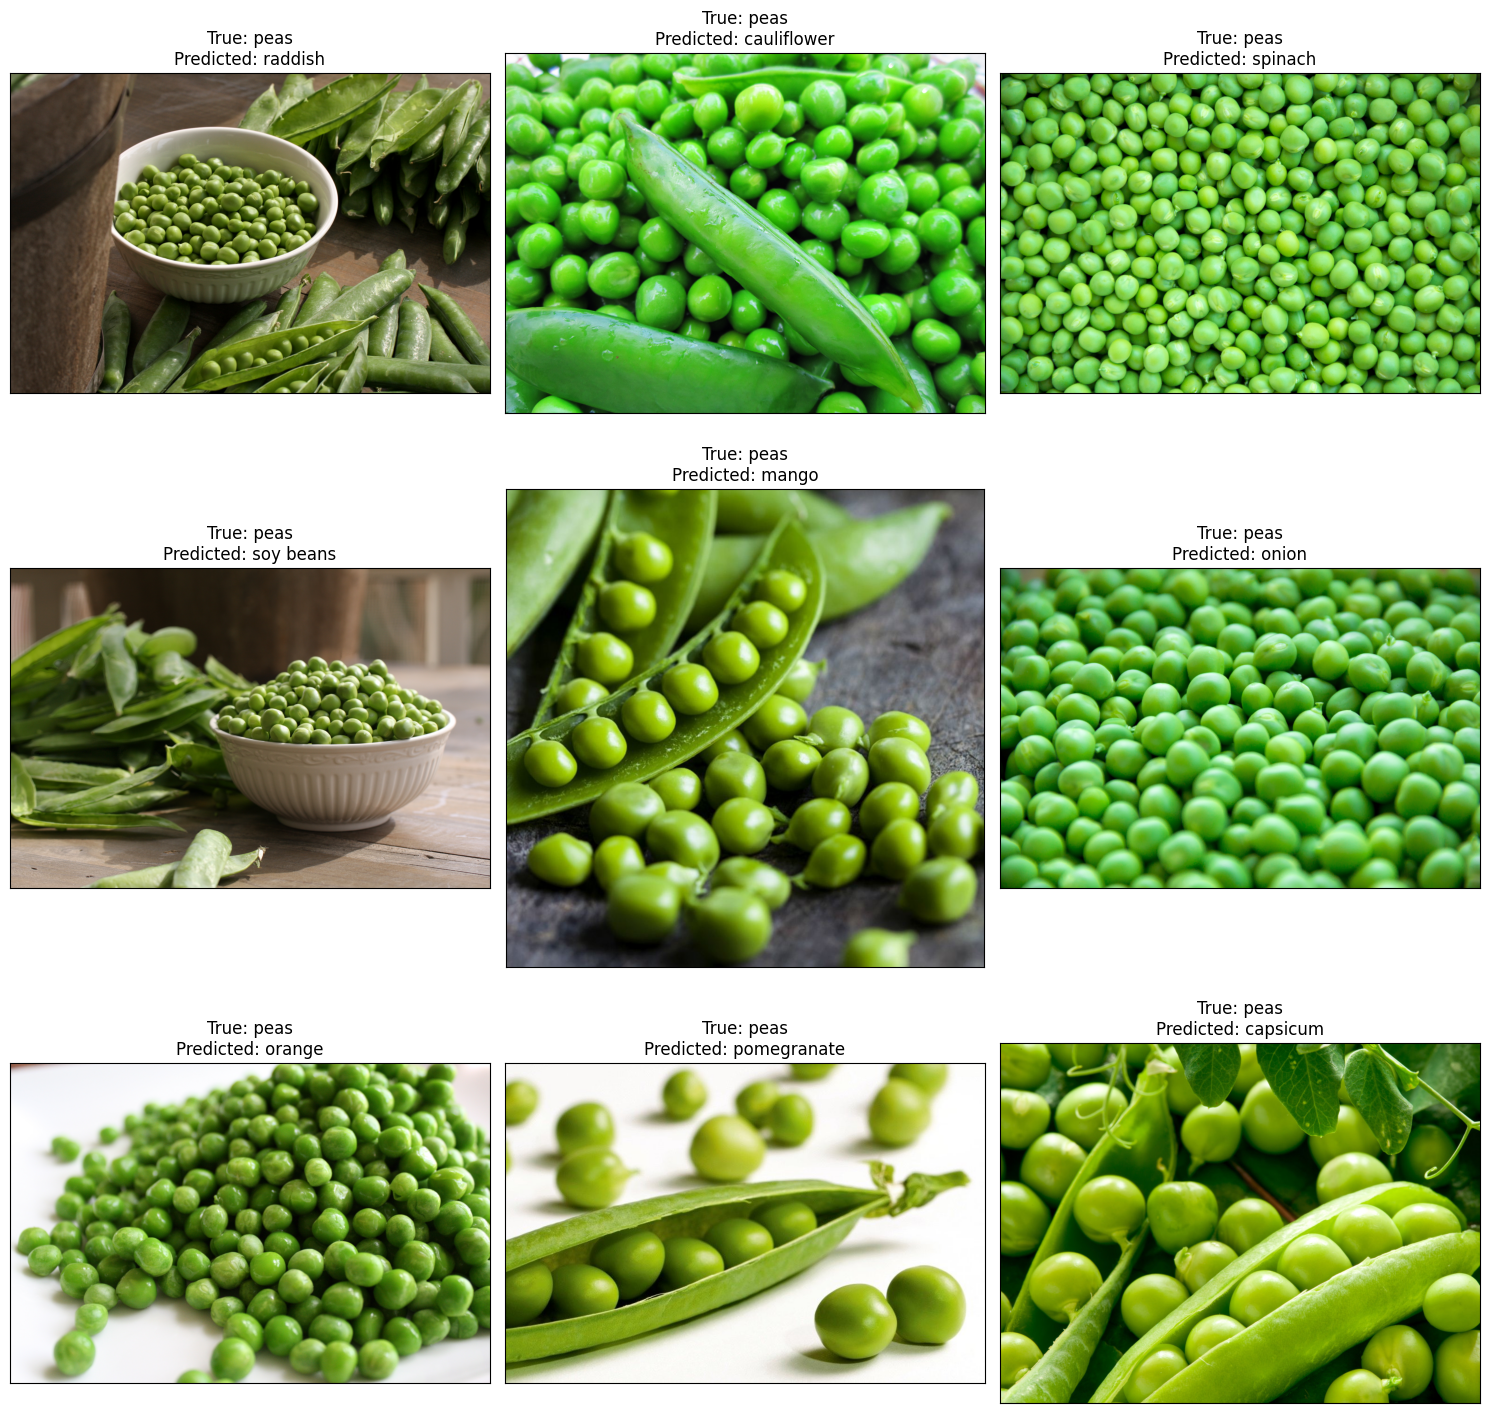

In [52]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Use 'image' column instead of 'Filepath' to access image paths
    ax.imshow(plt.imread(test_df.image.iloc[i]))
    ax.set_title(f"True: {test_df.label.iloc[i]}\nPredicted: {pred[i]}") # Use 'label' instead of 'Label'
plt.tight_layout()
plt.show()

In [25]:
resnet_model.evaluate(test_data)

12/12 [==============================] - 63s 5s/step - loss: 0.1490 - accuracy: 0.9666


[0.14898572862148285, 0.9665738344192505]